# Challenge Assignment
## Cliff Walking with Reinforcement Learning

## CSCI E-82A

### Name: Noah Peart

>**Make sure** you include your name along with the name of your team and team members in the notebook you submit.

**Your name and team name here:** Horse

## Introduction

In this challenge you will apply Monte Carlo reinforcement learning algorithms to a classic problem in reinforcement learning, known as the **cliff walking problem**. The cliff walking problem is a type of game. The goal is for the agent to find the highest reward (lowest cost) path from a starting state to the goal.   

There are a number of versions of the cliff walking problems which have been used as research benchmarks over the years. You can find a short discussion of the cliff walking problem on page 132 of Sutton and Barto, second edition.    

In the general cliff walking problem the agent starts in one corner of the state-space and must travel to goal, or terminal state, in another corner of the state-space. Between the starting state and goal state there is an area with a **cliff**. If the agent falls off a cliff it is sent back to the starting state. A schematic diagram of the state-space is shown in the diagram below.      

<img src="CliffWalkingDiagram.JPG" alt="Drawing" style="width:500px; height:400px"/>
<center> State-space of cliff-walking problem </center>



### Problem Description

The agent must learn a policy to navigate from the starting state to the terminal state. The properties this problem are as follows:

1. The state-space has two **continuous variables**, x and y.
2. The starting state is at $x = 0.0$, $y = 0.0$. 
3. The terminal state has two segments:
  - At $y = 0.0$ is in the range $9.0 \le x \le 10.0$. 
  - At $x = 10.0$ is in the range $0.0 \le y \le 1.0$.  
4. The cliff zone is bounded by:
  - $0.0 \le y \le 1.0$ and 
  - $1.0 \le x \le 9.0$. 
5. An agent entering the cliff zone is returned to the starting state.
6. The agent moves 1.0 units per time step. 
7. The 8 possible **discrete actions** are moves in the following directions:  
  - +x, 
  - +x, +y,
  - +y
  - -x, +y,
  - -y,
  - -x, -y,
  - -y, and
  - +x, -y. 
8. The rewards are:
  - -1 for a time step in the state-space,
  - -10 for colliding with an edge (barrier) of the state-space,
  - -100 for falling off the cliff and returning to the starting state, and 
  - +1000 for reaching the terminal or goal state. 
  


## Instructions

In this challenge you and your team will do the following. Include commentary on each component of your algorithms. Make sure you answer the questions.  

### Environment Simulator   

Your reinforcement learning agent cannot contain any information about the environment other that the starting state and the possible actions. Therefore, you must create an environment simulator, with the following input and output:
- Input: Arguments of state, the $(x,y)$ tuple, and discrete action
- Output: the new state (s'), reward, and if the new state meets the terminal or goal criteria.

Make sure you test your simulator functions carefully. The test cases must include, steps with each of the actions, falling off the cliff from each edge, hitting the barriers, and reaching the goal (terminal) edges. Errors in the simulator will make the rest of this challenge difficult.   

> **Note**: For this problem, coordinate state is represented by a tuple of continuous variables. Make sure that you maintain coordinate state as continuous variables for this problem. 

In [1]:
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy.linalg as la
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd

%matplotlib inline
%precision 3

'%.3f'

In [2]:
# Representations of actions and accessor functions
moves = [(0,1), (0,-1), (1,0), (1,1), (1,-1), (-1,0), (-1,1), (-1,-1)]

def vec_to_move(vec):
    v = np.array(vec, dtype=np.float)
    if (sum(abs(v)) > 1):
        v *= 0.707
    return v

def get_actions(actions=moves):
    """Convert actions to numpy arrays, and create reverse lookup tables."""
    vecs_normalized = list(map(lambda x: vec_to_move(x), actions))
    return vecs_normalized, {a: i for i,a in enumerate(actions)},\
        {i: a for i,a in enumerate(actions)}

def get_action_index(action):
    """Return index from action tuple."""
    return actions_index[action]

def get_index_action(index):
    """Return action tuple from index."""
    return actions_raw[index]

actions, actions_index, index_actions = get_actions()

In [3]:
actions

[array([0., 1.]),
 array([ 0., -1.]),
 array([1., 0.]),
 array([0.707, 0.707]),
 array([ 0.707, -0.707]),
 array([-1.,  0.]),
 array([-0.707,  0.707]),
 array([-0.707, -0.707])]

In [4]:
def is_terminal(loc):
    """Return True if x,y is in the terminal state."""
    x, y = loc
    return (y <= 0 and x >= 9) or (x >= 10 and y <= 1)

def sim_environment(loc, action):
    """
    Update current LOC with ACTION.
    :loc is a numpy array of (x, y) of current location
    :action is a numpy array representing movement vector (x, y)
    """
    prev = loc
    loc = loc + action

    # If hits a wall, stays in initial location
    if loc[0] < 0 or loc[0] > 9 or loc[1] < 0 or loc[1] > 9:
        return prev, -10, False

    # Returns to initial location if falls off of cliff
    if loc[0] >= 1 and loc[0] <= 9 and loc[0] <= 1:
        return np.array([0,0]), -100, False

    if is_terminal(loc):
        return loc, 1000, True
    
    return loc, -1, False

### Grid Approximation

The state-space of the cliff walking problem is continuous. Therefor, you will need to use a **grid approximation** to construct a policy. The policy is specified as the probability of action for each grid cell. For this problem, use a 10x10 grid. 

> **Note:** While the policy uses a grid approximation, state should be represented as continuous variables.

In [10]:
def state(x, x_lims = (0.0,10.0), n_tiles = 10):
    """Function to compute tile state given positon"""
    state = int((x - x_lims[0])/(x_lims[1] - x_lims[0]) * float(n_tiles))
    if state > n_tiles - 1:
        state = n_tiles - 1
    return state

def grid_state(loc):
    """Convert x,y coordinates into single state value."""
    return state(loc[0]) + 10 * state(loc[1])

def grid_index(num):
    """Convert state to x,y coordinates in grid."""
    return num % 10, num // 10

# Monte Carlo State Value Estimation
def take_action(loc, policy, actions=actions):
    '''
    Function takes action given state using the transition probabilities 
    of the policy.
    '''
    ## Find the action given the transistion probabilities defined by the policy.
    x_grid, y_grid = state(loc[0]), state(loc[1])
    action = actions[nr.choice(8, p = policy[x_grid][y_grid])]
    loc, is_terminal, reward =\
        sim_environment(np.array([x_grid, y_grid]), action)
    return action, loc, is_terminal, reward

### Initial Policy

Start with a uniform initial policy. A uniform policy has an equal probability of taking any of the 8 possible actions for each cell in the grid representation.     

> **Note:** As has already been stated, the coordinate state representation for this problem is a tuple of coordinate values. However, policy, state-values and action-values are represented with a grid approximation. 

> **Hint:** You may wish to use a 3-dimensional numpy array to code the policy for this problem. With 8 possible actions, this approach will be easier to work with. 



In [6]:
def get_initial_policy(nactions, x, y):
    """
    Generate initial policy given a number of actions and 
    x,y-dimensions of grid
    """
    # ensure lists aren't pointers to same memory
    ip = [[[1./nactions for i in range(nactions)]
           for j in range(x)]
          for k in range(y)]
    return np.array(ip)

initial_policy = get_initial_policy(8, 10, 10)
initial_policy[0]

array([[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]])

### Monte Carlo State Value Estimation   

For the initial uniform policy, compute the state values using the Monte Carlo RL algorithm:
1. Compute and print the state values for each grid in the representation. Use at least 1,000 episodes. This will take some time to execute.      
2. Plot the grid of state values, as an image (e.g. matplotlib [imshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html)). 
3. Compute the Forbenious norm (Euclidean norm) of the state value array with [numpy.linalg.norm](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html). You will use this figure as a basis to compare your improved policy. 

Study your plot to ensure your state values seem correct. Do these state values seem reasonable given the uniform policy and why? Make sure you pay attention to the state values of the cliff zone.    

> **Hint:** Careful testing at each stage of your algorithm development will potentially save you considerable time. Test your function(s) to for a single episode to make sure your algorithm converges. Then test for say 10 episodes to ensure the state values update in a reasonable manner at each episode.    

> **Note:** The Monte Carlo episodes can be executed in parallel for production systems. The Markov chain of each episode is statistically independent. 

In [7]:
def MC_episode(policy, G, n_visits): 
    '''
    Function creates the Monte Carlo samples of one episode.
    This function does most of the real work
    '''
    ## For each episode we use a list to keep track of states we have visited.
    ## Once we visit a state we need to accumulate values to get the returns
    states_visited = np.zeros(100, dtype=np.bool)
    visited = []
    
    ## Find the starting state
    loc_current = np.array([0, 0])
    current_state = grid_state(loc_current)
    terminal = False
    g = 0.0
    #i = 0
    #plt.axis([0, 10, 0, 10])
    #plt.scatter(x_current, y_current)
    while not terminal:
        ## Find the next action and reward
        action, loc_prime, terminal, reward = take_action(loc_current, policy)
        #print("from: " + str((x_current, y_current, action)))
        #print("to: " + str((x_prime, y_prime, is_terminal, reward)))
        ## Add the reward to the states visited if this is a first visit  
        if states_visited[current_state]:
            ## Mark that the current state has been visited 
            states_visited[current_state] = True
            visited.append(current_state)
            ## Add the reward to states visited 
            for state in visited:
                n_visits[state] = n_visits[state] + 1.0
                G[state] = G[state] + (reward - G[state])/n_visits[state]
        
        ## Update the current state for next transition
        current_state = grid_state(loc_prime) 
        #i = i + 1
        #plt.scatter(x_current, y_current)
    #plt.show()
    return (G, n_visits) 

def MC_state_values(policy, n_episodes, verbose=False):
    """
    Function that evaluates the state value of 
    a policy using the Monte Carlo method.
    """
    ## Create list of states 
    n_states = 100
    
    ## An array to hold the accumulated returns as we visit states
    G = np.zeros((n_states))
    
    ## An array to keep track of how many times we visit each state so we can 
    ## compute the mean
    n_visits = np.zeros((n_states))
    
    ## Iterate over the episodes
    for i in range(n_episodes):
        G, n_visits = MC_episode(policy, G, n_visits)
        if verbose and n_episodes % 100 == 0: print(f"episode: {i}")

    return G

In [8]:
# Functions to display state values
def show_state_values(G):
    """Show state values with origin in bottom left."""
    res = [x[::-1] for x in G]
    return res[::-1]


def plot_state_values(G):
    """Plot state values as image, with origin in bottom left."""
    res = [x[::-1] for x in G]
    plt.imshow(res, origin='lower')
    
    
def state_value_norm(G):
    """Euc. norm of state values."""
    return la.norm(G)

In [13]:
# Compute state values for 1000 episodes
G = MC_state_values(initial_policy, 1000, verbose=True).reshape((10,10))

In [12]:
# Show state values with origin in bottom left
show_state_values(G)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

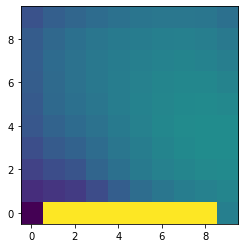

In [43]:
plot_state_values(G)

In [39]:
state_value_norm(G)

52.71426886416521

ANS:  Yes, these state values do seem pretty reasonable.  The cliff values are 0 and they are lower further from the goal point and around the edges/cliff where the possible penalties are the highest. They tend to become more positive as they approach the goal, as expected.

### Monte Carlo State Policy Improvement   

Finally, you will perform Monte Carlo RL policy improvement:
1. Starting with the uniform policy, compute action-values for each grid in the representation. Use at least 1,000 episodes.      
2. Use these action values to find an improved policy.
3. To evaluate your updated policy compute the state-values for this policy.  
4. Plot the grid of state values for the improved policy, as an image. 
5. Compute the Forbenious norm (Euclidean norm) of the state value array. 

Compare the state value plot for the improved policy to the one for the initial uniform policy. Does the improved state values increase generally as distance to the terminal states decreases?  Is this what you expect and why?    

Compare the norm of the state values with your improved policy to the norm for the uniform policy. Is the increase significant?  

> **Hint:** Careful testing at each stage of your algorithm development will potentially save you considerable time. Test your function(s) to for a single episode to make sure your algorithm converges. Then test for say 10 episodes to ensure the state values update in a reasonable manner at each episode.   

> **Note:** You could continue to improve policy using the general policy improvement algorithm (GPI). In the interest of time, you are not required to do so here. 

In [ ]:
def MC_action_value_episode(policy, Q, n_visits, inital_state, n_states, n_actions):
    '''
    Function creates the Monte Carlo samples of action values for one episode.
    This function does most of the real work.
    '''
    ## For each episode we use a list to keep track of states we have visited.
    ## Once we visit a state we need to accumulate values to get the returns
    state_actions_visited = np.zeros((n_states, n_actions))
    x_current = 0.0
    y_current = 0.0
    current_state = get_grid_state(x_current, y_current)
    terminal = False  

    while not terminal:
        ## Find the next action and reward
        #action, s_prime, reward, terminal = take_action(current_state, policy)
        action, x_prime, y_prime, terminal, reward =\
            take_action(x_current, y_current, policy)
        action_idx = get_action_index(action)         
        
        ## Check if this state-action has been visited.
        if state_actions_visited[current_state, action_idx] != 1.0:
            ## Mark that the current state-action has been visited 
            state_actions_visited[current_state, action_idx] = 1.0  
            ## This is first vist MS, so must loop over all state-action pairs and 
            ## add the reward and increment the count for the ones visited.
            for s,a in itertools.product(range(n_states), range(n_actions)):
                ## Add reward to if these has been a visit to the state
                if state_actions_visited[s,a] == 1.0:
                    n_visits[s,a] = n_visits[s,a] + 1.0
                    Q[s,a] = Q[s,a] + (reward - Q[s,a])/n_visits[s,a]
        
        ## Update the current state for next transition
        current_state = get_grid_state(x_prime, y_prime)
        x_current = x_prime
        y_current = y_prime
    
    return (Q, n_visits)

In [64]:
def MC_action_values(policy, Q, n_episodes, inital_state, verbose=False):
    '''
    Function evaluates the action-values given a policy for the specified number
    of episodes and initial state
    '''
    n_states = 100
    n_actions = 8
    ## Array to count visits to action-value pairs
    n_visits = np.zeros((n_states, n_actions))
    ## Dictionary to hold neighbor states
    neighbors = {}
    
    for i in range(n_episodes):
        ## One episode of MC
        if verbose and i % 10 == 0: print (f"running episode #{i}")
        Q, n_visits =\
            MC_action_value_episode(
                policy, Q, n_visits, initial_state, n_states, n_actions)
    return Q


def print_Q(Q):
    """Helper to pretty print Q output"""
    Q = pd.DataFrame(Q, columns = ['N', 'S', 'E', 'NE', 'SE', 'W', 'NW', 'SW'])
    print(Q)

In [70]:
# Compute action values (long time)
n_episodes = 1000
initial_state = 0
Q = np.zeros((100, 8))

Q = MC_action_values(initial_policy, Q, n_episodes, initial_state, verbose=True)

running episode #0
running episode #10
running episode #20
running episode #30
running episode #40
running episode #50
running episode #60
running episode #70
running episode #80
running episode #90
running episode #100
running episode #110
running episode #120
running episode #130
running episode #140
running episode #150
running episode #160
running episode #170
running episode #180
running episode #190
running episode #200
running episode #210
running episode #220
running episode #230
running episode #240
running episode #250
running episode #260
running episode #270
running episode #280
running episode #290
running episode #300
running episode #310
running episode #320
running episode #330
running episode #340
running episode #350
running episode #360
running episode #370
running episode #380
running episode #390
running episode #400
running episode #410
running episode #420
running episode #430
running episode #440
running episode #450
running episode #460
running episode #470
run

In [81]:
def update_policy(policy, Q, epsilon):
    '''
    Updates the policy based on estimates of Q using an epslion greedy
    algorithm. The action with the highest action value is used.
    '''
    
    ## Find the keys for the actions in the policy
    keys = actions
    
    ## Iterate over the states and find the maximm action value.
    for state in range(100):
        ## First find the index of the max Q values  
        q = Q[state,:]
        max_action_index = np.where(q == max(q))[0]

        ## Find the probabilities for the transitions
        n_transitions = float(len(q))
        n_max_transitions = float(len(max_action_index))
        p_max_transitions =\
            (1.0 - epsilon *(n_transitions - n_max_transitions))/(n_max_transitions)
        nx, ny = grid_index(state)
        
        ## Now assign the probabilities to the policy as epsilon greedy.
        for key in keys:
            index = get_action_index(key)
            if(index in max_action_index): policy[nx][ny][index] = p_max_transitions
            else: policy[nx][ny][index] = epsilon
    return policy

In [91]:
# Update policy based on Q
policy = update_policy(deepcopy(initial_policy), Q, 0.0001)
policy[0][9]

[0.000, 0.999, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]

In [92]:

# def get_action_index(action):
#     if (action == (0,1)): return 0
#     elif (action == (0,-1)): return 1
#     elif (action == (1,0)): return 2
#     elif (action == (1,1)): return 3
#     elif (action == (1,-1)): return 4
#     elif (action == (-1,0)): return 5
#     elif (action == (-1,1)): return 6
#     elif (action == (-1,-1)): return 7
    
    
def arrow_xy(action, prob):
    ## Position change given action:
    if(action == 0): # move right
        a_out = [0, 1]
    elif(action == 1): # move right-up
        a_out = [0, -1]
    elif(action == 2): # move up
        a_out = [1, 0]
    elif(action == 3): # move left-up
        a_out = [1, 1]
    elif(action == 4): # move left
        a_out = [1, -1]
    elif(action == 5): # move left-down
        a_out = [-1, 0]
    elif(action == 6): # move down
        a_out = [-1, 1]
    elif(action == 7): # move right-down
        a_out = [-1, -1]
    return [prob*z for z in a_out]

def display_policy(policy, num_cells = 10, lims = 10.0):
    '''
    Funciton plots arrows in the direction of actions with length 
    of arrows proportional to probability

    Policy argument must be a numpy array with dimensions:
    grid x-dimension cell index
    grid y-dimension cell index
    acton index
    '''
    ## Find max arrow length 
    cell_width = lims/float(num_cells)
    arrow_length = 0.5 * cell_width

    ## Set up the figure area
    fig = plt.figure(figsize=(8, 8)) # define plot area
    ax = fig.gca() # define axis 

    ## Iterate over the grid and plot
    for x_indx, y_indx, action in product(range(num_cells),range(num_cells),range(8)):
        ## Find endpoints of the line segment
        move = arrow_xy(action, policy[x_indx][y_indx][action])
        x0 = x_indx * cell_width + arrow_length
        x1 = x0 + move[0]
        y0 = y_indx * cell_width + arrow_length
        y1 = y0 + move[1]
        ## now plot 
        # ax.plot([x0,x1],[y0,y1])
        ax.annotate(' ', xytext =(x0,y0), xy = (x1,y1), arrowprops = ({'arrowstyle':'->'}))

    ## Now plot the grid
    ## first the vertical lines
    for indx in range(num_cells-1):
        x = cell_width *(indx+1)
        ax.plot([x,x],[0.0,lims], linestyle='dashed', color='green')
    ## now the horrizontal lines
    for indx in range(num_cells-1):
        y = cell_width *(indx+1)
        ax.plot([0.0,lims],[y,y], linestyle='dashed', color='green') 
    ## and boundaries
    ax.plot([0.0,0.0], [0.0,lims], color = 'black')
    ax.plot([0.0,lims], [0.0,0.0], color = 'black')
    ax.plot([lims,0.0], [lims,lims], color = 'black')
    ax.plot([lims,lims], [0.0,lims], color = 'black')

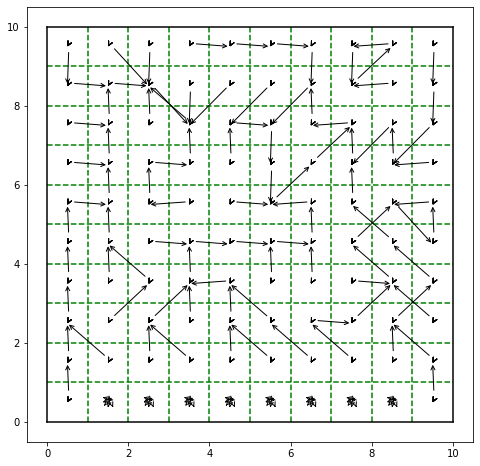

In [93]:
display_policy(np.array(policy))

ANS:

ANS:

ANS:

## Solution

Create cells below for your solution to the stated problem. Be sure to include some Markdown text and code comments to explain each component of your algorithm. 